### 1. Instalação e importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

### 2. Carregar dados

In [2]:
caminho = '/home/seiji/Documentos/Ebanx/ProjetoGeral/Saude-Mental-Curitiba-Regiao/notebooks/dados_cheirosos.csv'
df = pd.read_csv(caminho)

### 3. Criar coluna de Data Real (datatime)

In [3]:
df['data'] = pd.to_datetime({
    'year': df['ano_atendimento'],
    'month': df['mes_atendimento'],
    'day': 1
})

### 4. Agrupar pir mês e tipo de procedimento

Amostra da Série Temporal:
procedimento_ambulatorial    y
data                          
2014-01-01                 647
2014-02-01                 696
2014-03-01                 666
2014-04-01                 710
2014-05-01                 782


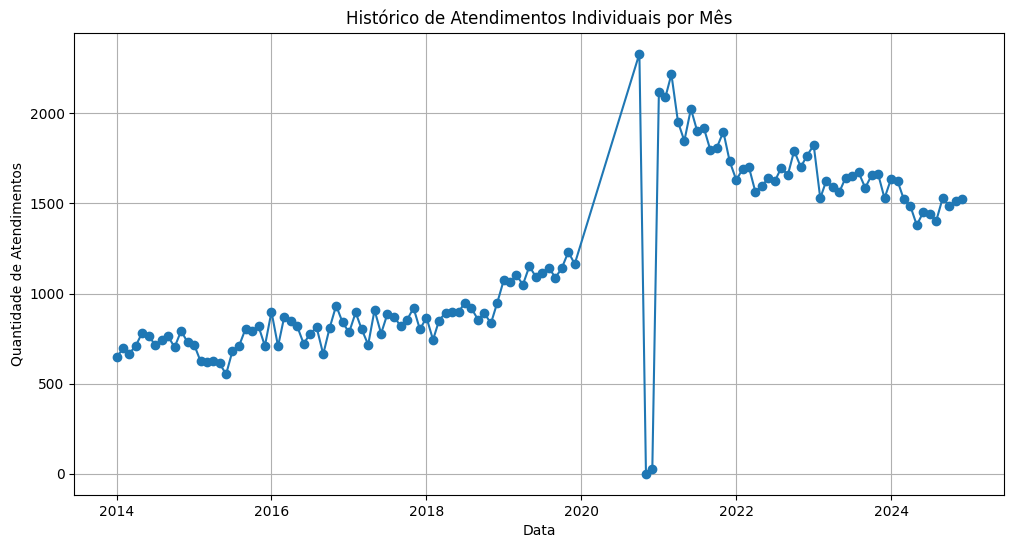

In [4]:
# Isso cria uma tabela onde as linhas são meses e as colunas sao a contagem de cada procedimento
df_temporal = df.groupby(['data', 'procedimento_ambulatorial']).size().unstack(fill_value=0)

# Focar em prever a demanda de 'Atendimento Individual'
ts = df_temporal[['Atendimento Individual']].rename(columns={'Atendimento Individual': 'y'})

# Ordenar por data
ts = ts.sort_index()

print("Amostra da Série Temporal:")
print(ts.head())

# Plotar para ver a tendência
plt.figure(figsize=(12, 6))
plt.plot(ts.index, ts['y'], marker='o')
plt.title("Histórico de Atendimentos Individuais por Mês")
plt.xlabel("Data")
plt.ylabel("Quantidade de Atendimentos")
plt.grid(True)
plt.show()

### 5. Interpolação ("liga os pontos" entre o último dado válido antes da queda e o primeiro dado válido depois)

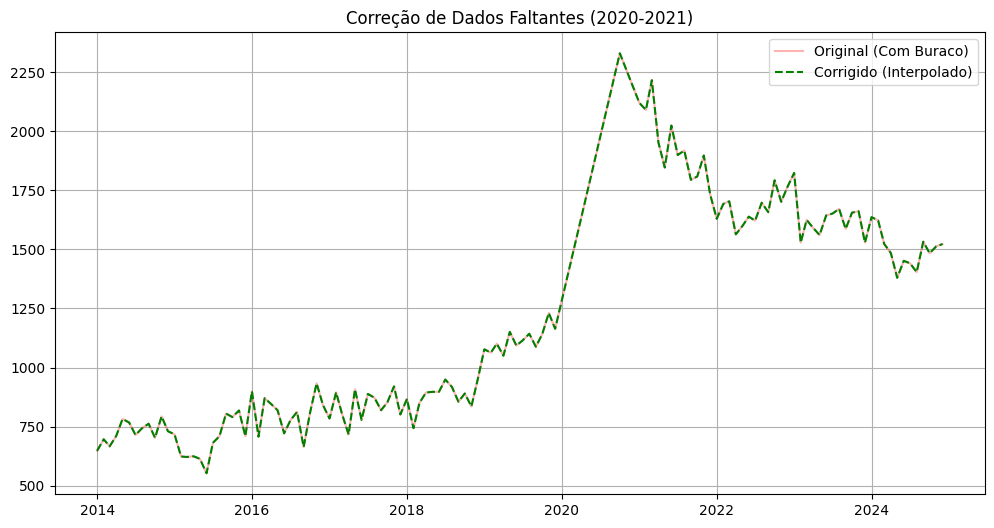

In [13]:
# 1. Identificar o "Buraco": Transformar Zeros (ou valores muito baixos) em NaN
# Vamos assumir que qualquer mês com menos de 100 atendimentos é erro de dado
ts['y_tratado'] = ts['y'].apply(lambda x: np.nan if x < 100 else x)

# 2. Aplicar Interpolação (Ligar os pontos)
# O método 'time' é inteligente: ele considera a distância temporal entre os meses
ts['y_tratado'] = ts['y_tratado'].interpolate(method='time')

# 3. Visualizar o Antes e Depois
plt.figure(figsize=(12, 6))
plt.plot(ts.index, ts['y'], label='Original (Com Buraco)', color='red', alpha=0.3)
plt.plot(ts.index, ts['y_tratado'], label='Corrigido (Interpolado)', color='green', linestyle='--')

plt.title("Correção de Dados Faltantes (2020-2021)")
plt.legend()
plt.grid(True)
plt.show()

# 4. Atualizar a coluna principal para o modelo usar
ts['y'] = ts['y_tratado']

# Suavizar picos artificiais usando média de 3 meses
ts['y_suavizado'] = ts['y'].rolling(window=3, center=True).mean()
# Se usar isso, lembre de preencher as pontas que ficam vazias
ts['y'] = ts['y_suavizado'].fillna(ts['y'])

### 6. Criar Features de Tempo (Lags)

In [14]:
# Lag_1: Valor do mes anterior
# Lag_2: Valor de 2 meses atrás
# Lag_12: Valor do mesmo mes no ano passado (Sazonalidade)

df_ml = ts.copy()
df_ml['mes'] = df_ml.index.month  # Sazonalidade do mês (1 a 12)
df_ml['ano'] = df_ml.index.year   # Tendência anual

# Criar atrasos (Atenção: isso gera NaNs nas primeiras linhas)
df_ml['lag_1'] = df_ml['y'].shift(1)
df_ml['lag_2'] = df_ml['y'].shift(2)
df_ml['lag_3'] = df_ml['y'].shift(3)
df_ml['media_movel_3m'] = df_ml['y'].rolling(window=3).mean().shift(1) # Media dos ultimos 3 meses

# Remover linhas vazias (os primeiros meses nao tem passado para olhar)
df_ml = df_ml.dropna()

print("Dataset preparado para ML:")
df_ml.head()

Dataset preparado para ML:


procedimento_ambulatorial,y,y_tratado,y_suavizado,mes,ano,lag_1,lag_2,lag_3,media_movel_3m
data,,,,,,,,,
2014-04-01,719.333333,710.0,719.333333,4,2014,690.666667,669.666667,647.000000,669.111111
2014-05-01,753.000000,782.0,753.000000,5,2014,719.333333,690.666667,669.666667,693.222222
2014-06-01,754.333333,767.0,754.333333,6,2014,753.000000,719.333333,690.666667,721.000000
2014-07-01,741.333333,714.0,741.333333,7,2014,754.333333,753.000000,719.333333,742.222222
2014-08-01,739.666667,743.0,739.666667,8,2014,741.333333,754.333333,753.000000,749.555556


### 7. Separar Treino (Passado) e Teste (Futuro)

In [15]:
# Vamos usar os últimos 6 meses para teste
meses_teste = 6
split_index = len(df_ml) - meses_teste

treino = df_ml.iloc[:split_index]
teste = df_ml.iloc[split_index:]

# 2. Separar x e y
features = ['mes', 'ano', 'lag_1', 'lag_2', 'lag_3', 'media_movel_3m']
alvo = 'y'

X_train = treino[features]
y_train = treino[alvo]
X_test = teste[features]
y_test = teste[alvo]

# 3. Treinar Regressor (Agora é RandomForestREGRESSOR, nao Classifier)
modelo_ts = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_ts.fit(X_train, y_train)

# 4. Prever
previsoes = modelo_ts.predict(X_test)

### 8.Avaliação (gráfico real vs previsto)

Erro Médio Absoluto (MAE): 19.48
Isso significa que o modelo erra, em média, 19 atendimentos para cima ou para baixo.


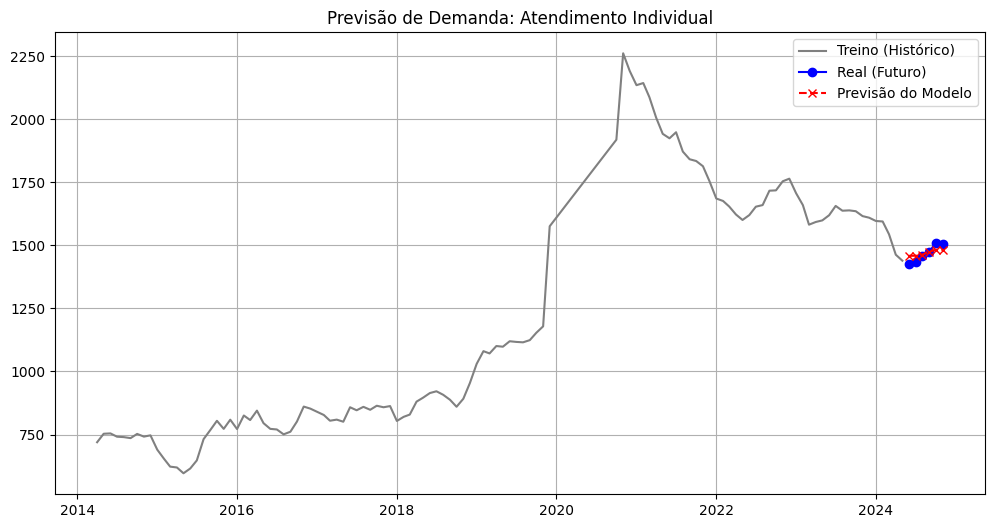

In [19]:
# 1. Calcular Erro
mae = mean_absolute_error(y_test, previsoes)
print(f"Erro Médio Absoluto (MAE): {mae:.2f}")
print(f"Isso significa que o modelo erra, em média, {int(mae)} atendimentos para cima ou para baixo.")

# 2. Plotar Resultado
plt.figure(figsize=(12, 6))

# Dados de Treino
plt.plot(treino.index, y_train, label='Treino (Histórico)', color='gray')

# Dados Reais de Teste
plt.plot(teste.index, y_test, label='Real (Futuro)', color='blue', marker='o')

# Previsão do Modelo
plt.plot(teste.index, previsoes, label='Previsão do Modelo', color='red', linestyle='--', marker='x')

plt.title("Previsão de Demanda: Atendimento Individual")
plt.legend()
plt.grid(True)
plt.show()